In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# For validation and test, do not use augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset_root = 'data/dataset' 
full_dataset = ImageFolder(root=dataset_root, transform=None)
print("Detected classes:", full_dataset.classes)

Detected classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [ ]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

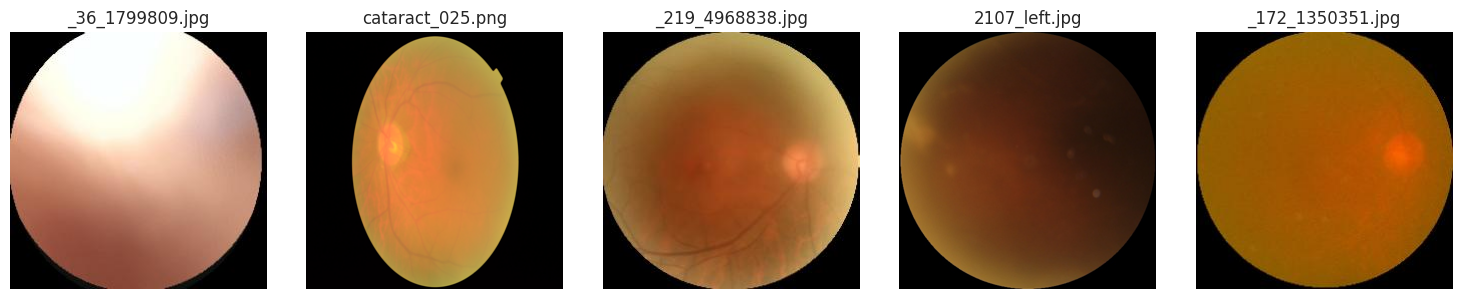

In [ ]:
path_to_visualize = "data/dataset/cataract"
visualize_images(path_to_visualize, num_images=5)

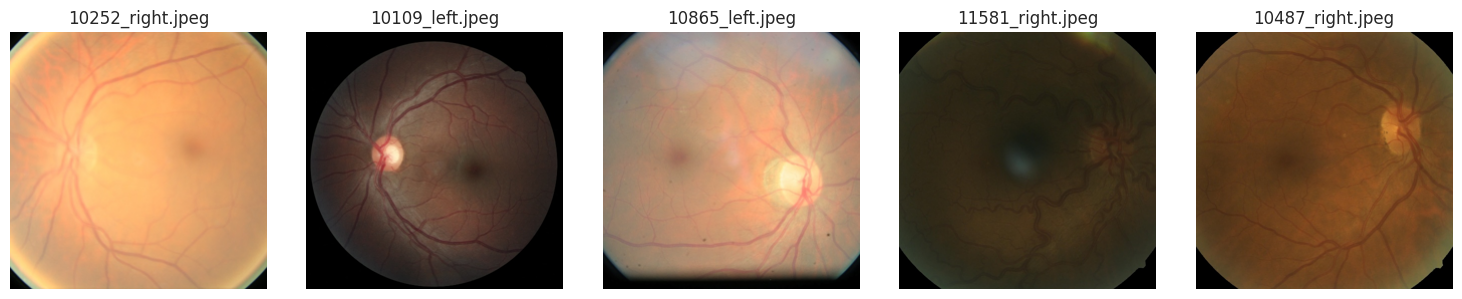

In [ ]:
path_to_visualize = "data/dataset/diabetic_retinopathy"
visualize_images(path_to_visualize, num_images=5)

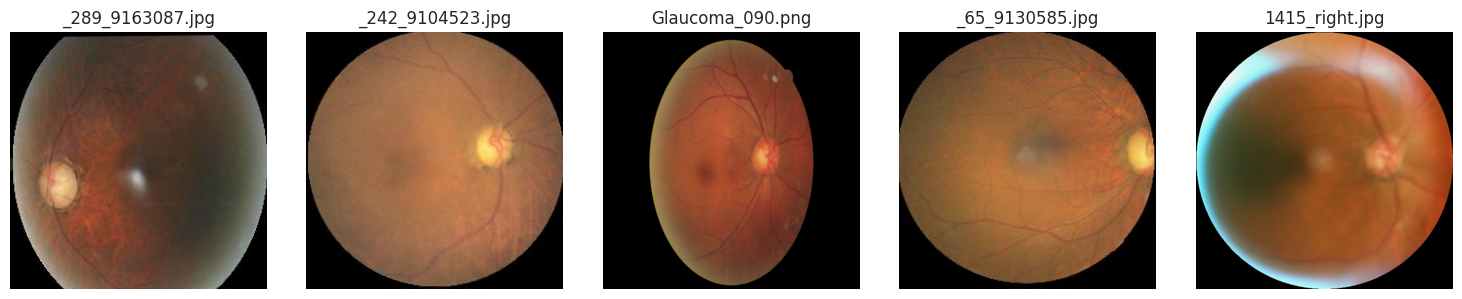

In [ ]:
path_to_visualize = "data/dataset/glaucoma"
visualize_images(path_to_visualize, num_images=5)

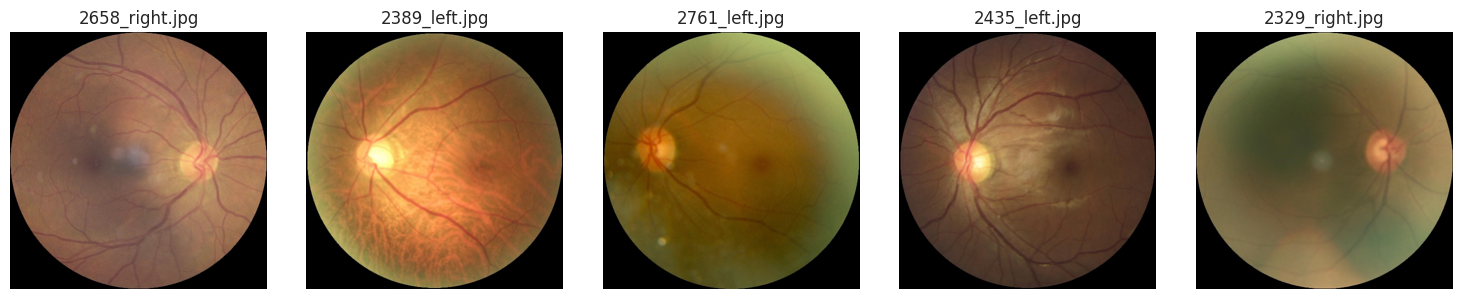

In [ ]:
path_to_visualize = "data/dataset/normal"
visualize_images(path_to_visualize, num_images=5)

In [ ]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size 

In [ ]:
print(f"Total size: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total size: 4217
Train size: 3373
Validation size: 421
Test size: 423


In [ ]:
def visualize_images(path, target_size=(256, 256), num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

In [ ]:
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(train_subset, transform=train_transform)
val_dataset   = TransformDataset(val_subset, transform=val_transform)
test_dataset  = TransformDataset(test_subset, transform=val_transform)


In [ ]:
batch_size = 64
num_workers = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

## <span style="color:rgb(255, 0, 60)">Resnet50</span>

In [ ]:
resnet50_model = models.resnet50(pretrained=True)
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, num_classes)
resnet50_model = resnet50_model.to(device)

/home/spandan/projects/eye_disease_classification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spandan/projects/eye_disease_classification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(resnet50_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_acc = 0.0
    best_model_wts = None
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        scheduler.step()

    print("Best validation accuracy: {:.4f}".format(best_acc))
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

def test_model_with_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    overall_acc = accuracy_score(all_labels, all_preds)
    print("\nOverall Test Accuracy: {:.4f}".format(overall_acc))

    class_names = full_dataset.classes
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("Per Class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"Class {i} ({class_names[i]}): {acc:.4f}")

    return overall_acc, report, per_class_acc


In [ ]:
num_epochs = 20
print("Training ResNet50 on new dataset with 80/10/10 split...")
trained_resnet50, resnet_train_losses, resnet_train_accs, resnet_val_losses, resnet_val_accs = train_model(
    resnet50_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs
)


/tmp/ipykernel_22072/2940410134.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training


Training ResNet50 on new dataset with 80/10/10 split...

Epoch 1/20


Training:   0%|          | 0/53 [00:00<?, ?it/s]/tmp/ipykernel_22072/2940410134.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/7 [00:00<?, ?it/s]        /tmp/ipykernel_22072/2940410134.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.7984, Train Acc: 0.6594
Val Loss: 0.6800, Val Acc: 0.7031

Epoch 2/20


Train Loss: 0.6225, Train Acc: 0.7406
Val Loss: 0.4668, Val Acc: 0.8100

Epoch 3/20


Train Loss: 0.5530, Train Acc: 0.7750
Val Loss: 0.3960, Val Acc: 0.8385

Epoch 4/20


Train Loss: 0.4953, Train Acc: 0.7940
Val Loss: 0.4446, Val Acc: 0.8242

Epoch 5/20


Train Loss: 0.4392, Train Acc: 0.8260
Val Loss: 0.4357, Val Acc: 0.8361

Epoch 6/20


Train Loss: 0.4194, Train Acc: 0.8328
Val Loss: 0.4253, Val Acc: 0.8527

Epoch 7/20


Train Loss: 0.4011, Train Acc: 0.8414
Val Loss: 0.3975, Val Acc: 0.8409

Epoch 8/20


Train Loss: 0.4066, Train Acc: 0.8411
Val Loss: 0.3980, Val Acc: 0.8575

Epoch 9/20


Train Loss: 0.3504, Train Acc: 0.8654
Val Loss: 0.3510, Val Acc: 0.8765

Epoch 10/20


Train Loss: 0.3334, Train Acc: 0.8681
Val Loss: 0.3434, Val Acc: 0.8931

Epoch 11/20


Train Loss: 0.3283, Train Acc: 0.8660
Val Loss: 0.3381, Val Acc: 0.8789

Epoch 12/20


Train Loss: 0.3075, Train Acc: 0.8746
Val Loss: 0.3634, Val Acc: 0.8955

Epoch 13/20


Train Loss: 0.2722, Train Acc: 0.8942
Val Loss: 0.3072, Val Acc: 0.9002

Epoch 14/20


Train Loss: 0.2675, Train Acc: 0.8945
Val Loss: 0.3196, Val Acc: 0.9050

Epoch 15/20


Train Loss: 0.2398, Train Acc: 0.9090
Val Loss: 0.3052, Val Acc: 0.9050

Epoch 16/20


Train Loss: 0.2441, Train Acc: 0.9034
Val Loss: 0.3081, Val Acc: 0.9050

Epoch 17/20


Train Loss: 0.2328, Train Acc: 0.9108
Val Loss: 0.2923, Val Acc: 0.9002

Epoch 18/20


Train Loss: 0.2324, Train Acc: 0.9131
Val Loss: 0.2925, Val Acc: 0.9074

Epoch 19/20


Train Loss: 0.2234, Train Acc: 0.9170
Val Loss: 0.2916, Val Acc: 0.9050

Epoch 20/20


Train Loss: 0.2288, Train Acc: 0.9114
Val Loss: 0.2927, Val Acc: 0.9074
Best validation accuracy: 0.9074


In [ ]:
torch.save(trained_resnet50.state_dict(), 'resnet50_model.pth')

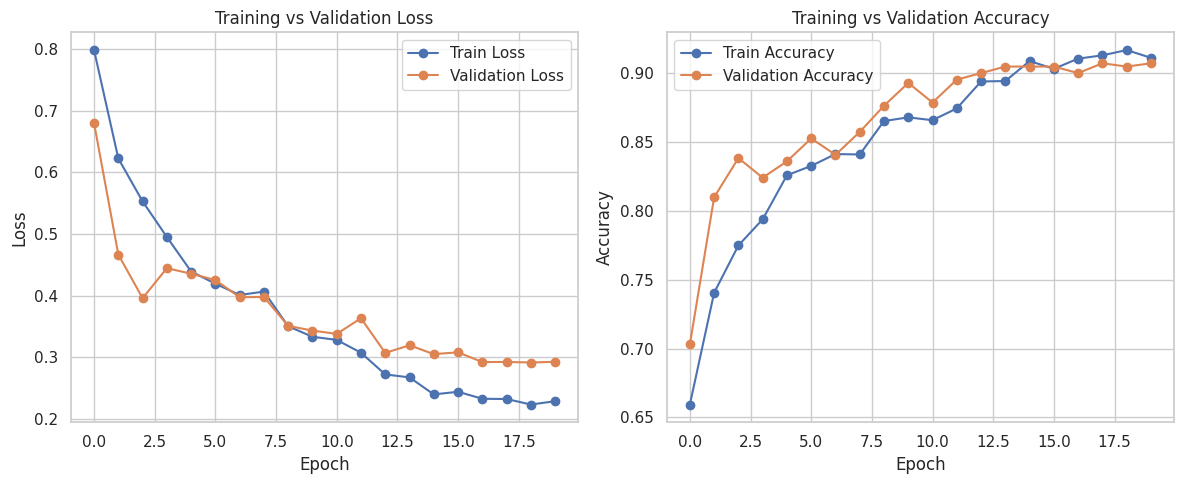

In [ ]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(resnet_train_losses, label="Train Loss", marker="o")
plt.plot(resnet_val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(resnet_train_accs, label="Train Accuracy", marker="o")
plt.plot(resnet_val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Overall Test Accuracy: 0.9078

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.93      0.95      0.94        93
diabetic_retinopathy       0.95      0.95      0.95       114
            glaucoma       0.92      0.82      0.87       107
              normal       0.85      0.92      0.88       109

            accuracy                           0.91       423
           macro avg       0.91      0.91      0.91       423
        weighted avg       0.91      0.91      0.91       423



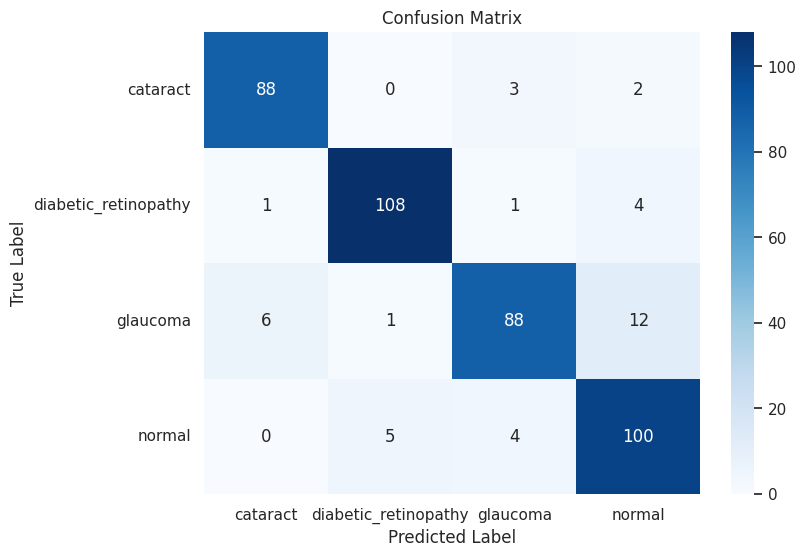

Per Class Accuracy:
Class 0 (cataract): 0.9462
Class 1 (diabetic_retinopathy): 0.9474
Class 2 (glaucoma): 0.8224
Class 3 (normal): 0.9174
Final Results for ResNet50:
Overall Accuracy: 0.9078

Classification Report:

                      precision    recall  f1-score   support

            cataract       0.93      0.95      0.94        93
diabetic_retinopathy       0.95      0.95      0.95       114
            glaucoma       0.92      0.82      0.87       107
              normal       0.85      0.92      0.88       109

            accuracy                           0.91       423
           macro avg       0.91      0.91      0.91       423
        weighted avg       0.91      0.91      0.91       423


Per Class Accuracy:
Class 0: 0.9462
Class 1: 0.9474
Class 2: 0.8224
Class 3: 0.9174


In [ ]:
overall_acc, class_report, per_class_acc = test_model_with_report(trained_resnet50, test_loader, device)

results = {
    "ResNet50": {
        "overall_accuracy": overall_acc,
        "classification_report": class_report,
        "per_class_accuracy": per_class_acc
    }
}

print("Final Results for ResNet50:")

overall_acc = results["ResNet50"]["overall_accuracy"]
print("Overall Accuracy: {:.4f}".format(overall_acc))

print("\nClassification Report:\n")
print(results["ResNet50"]["classification_report"])

print("\nPer Class Accuracy:")
per_class_acc = results["ResNet50"]["per_class_accuracy"]
for idx, acc in enumerate(per_class_acc):
    print("Class {}: {:.4f}".format(idx, acc))

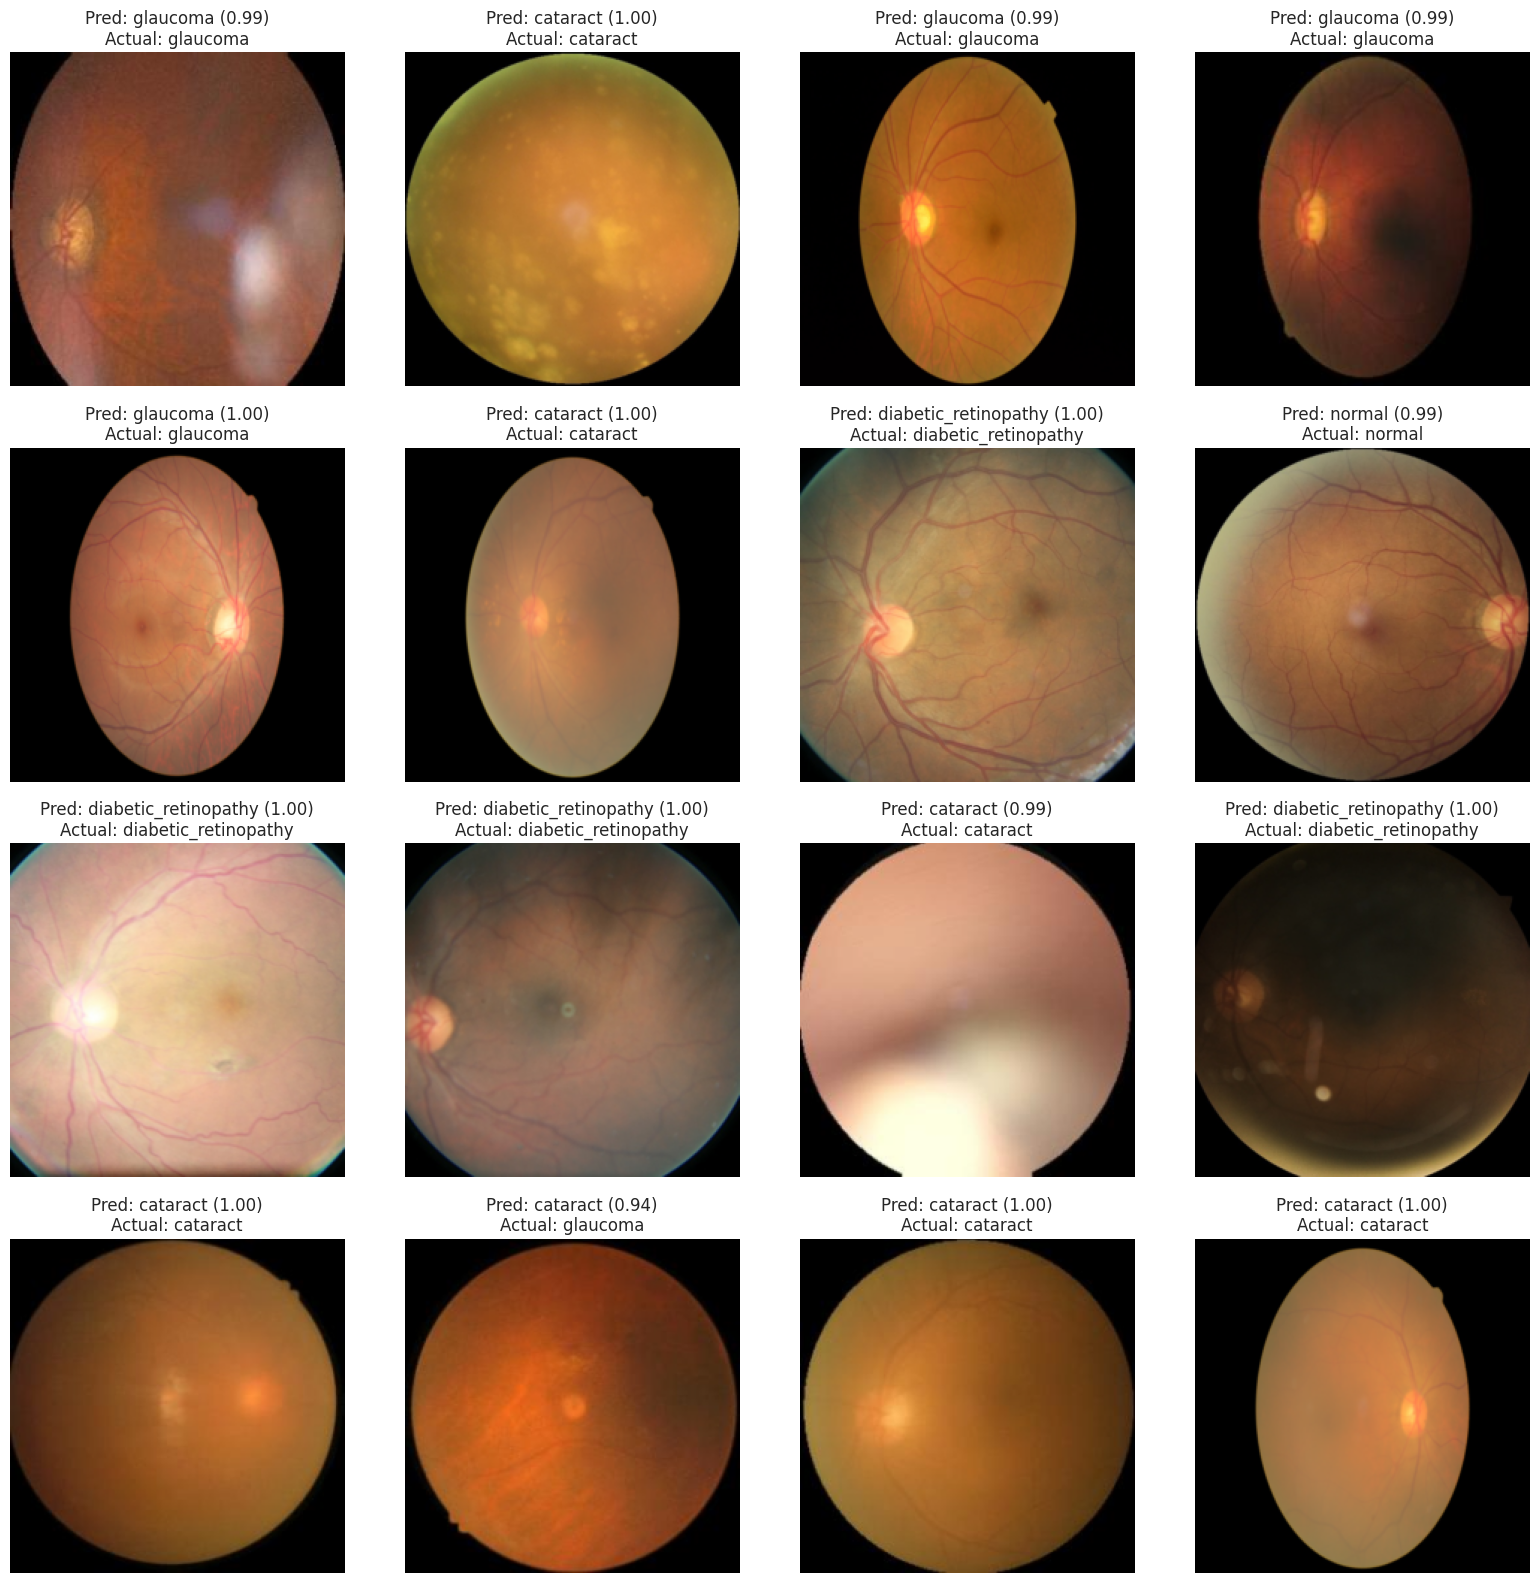

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

trained_resnet50.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = trained_resnet50(images)
    probabilities = F.softmax(outputs, dim=1)
    confidences, preds = torch.max(probabilities, dim=1)

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()
confidences = confidences.cpu()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def denormalize(img_tensor):
    # Convert from (C, H, W) to (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()  
    img = std * img + mean 
    return np.clip(img, 0, 1)  

class_names = full_dataset.classes

num_images = min(len(images), 16) 
cols = 4
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = np.array(axs).flatten()

for i in range(num_images):
    img = denormalize(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]
    conf = confidences[i].item()

    ax = axs[i]
    ax.imshow(img)
    ax.set_title(f"Pred: {pred_label} ({conf:.2f})\nActual: {true_label}")
    ax.axis("off")

for j in range(num_images, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
######################################
#  Common Inference and Plot Function
######################################
def run_inference_and_plot(model, dataloader, device, dataset_classes, title_prefix=""):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidences, preds = torch.max(probabilities, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    confidences = confidences.cpu()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    def denormalize(img_tensor):
        img = img_tensor.permute(1, 2, 0).numpy()
        img = std * img + mean
        return np.clip(img, 0, 1)

    num_images = min(len(images), 16) 
    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axs = np.array(axs).flatten()

    for i in range(num_images):
        img = denormalize(images[i])
        true_label = dataset_classes[labels[i]]
        pred_label = dataset_classes[preds[i]]
        conf = confidences[i].item()
        ax = axs[i]
        ax.imshow(img)
        ax.set_title(f"{title_prefix}Pred: {pred_label} ({conf:.2f})\nActual: {true_label}")
        ax.axis("off")
    for j in range(num_images, len(axs)):
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()



In [1]:
scripted = torch.jit.trace(trained_resnet50.cpu(), torch.randn(1,3,224,224))
scripted.save("resnet50_model.pt")


NameError: name 'torch' is not defined